In [1]:
import pandas as pd
import torch as tc
import numpy as np
import multiprocessing
import re
from panoramix.decompiler import decompile_bytecode
from transformers import DistilBertTokenizerFast
import torch
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [2]:
import web3
from web3 import Web3


def soft_decompile(byte_code):
    try:
        decompiled_code = decompile_bytecode(byte_code).text
        assert len(decompiled_code) > 200
        return decompiled_code
    except:
        try:
            byte_code = '0x' + byte_code[66:]
            decompiled_code = decompile_bytecode(byte_code).text
            assert len(decompiled_code) > 200
            return decompiled_code
        except:
            return "error"


def force_web3_code_decompile(contract_address):
    print("load from web3...")
    web3 = Web3(Web3.HTTPProvider("https://eth-mainnet.gateway.pokt.network/v1/lb/6266d6cdaa777e00391e0d29"))
    contract_bytecode = web3.eth.getCode(Web3.toChecksumAddress(contract_address))
    contract_bytecode_string = contract_bytecode.hex()
    decompiled_code = decompile_bytecode(contract_bytecode_string).text
    return decompiled_code

def simple_web3_code_decompile(byte_code):
    try:
        return decompile_bytecode(byte_code).text
    except:
        return "error"


def preprocess_code(code_str):
    code_str = code_str.replace("\n\n", "\n")
    lines = code_str.split('\n')

    # for line in lines:
    #     print(line)

    code_block = False
    for i, line in enumerate(lines):

        lines[i] += " ;"
        line += " ;"
        if line[:2] == "  " and not code_block:
            code_block = True
            lines[i] = line[2:]
            lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
            lines[i - 1] = lines[i - 1].replace(': ;', ' {')
        elif line[:2] == "  " and code_block:
            lines[i] = line[2:]
        elif line[:2] != "  " and code_block:
            code_block = False
            lines[i - 1] = lines[i - 1] + ' }'

        lines[i] = lines[i].replace('(', ' ( ')
        lines[i] = lines[i].replace(')', ' )')
        lines[i] = lines[i].replace('[', ' [ ')
        lines[i] = lines[i].replace(']', ' ]')
        lines[i] = lines[i].replace('.', ' . ')
        lines[i] = lines[i].replace('=', ' = ')

    code_block = False

    blocks_truncated = False
    while not blocks_truncated:
        blocks_truncated = True
        for i, line in enumerate(lines):
            if line[:2] == "  " and not code_block:
                code_block = True
                blocks_truncated = False
                lines[i] = line[2:]
                lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
                lines[i - 1] = lines[i - 1].replace(': ;', ' {')
            elif line[:2] == "  " and code_block:
                lines[i] = line[2:]
            elif line[:2] != "  " and code_block:
                code_block = False
                lines[i - 1] = lines[i - 1] + ' }'

    blocks_truncated = False
    while not blocks_truncated:
        blocks_truncated = True
        for i, line in enumerate(lines):
            if line[:2] == " " and not code_block:
                code_block = True
                blocks_truncated = False
                lines[i] = line[2:]
                lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
                lines[i - 1] = lines[i - 1].replace(': ;', ' {')
            elif line[:2] == " " and code_block:
                lines[i] = line[2:]
            elif line[:2] != " " and code_block:
                code_block = False
                lines[i - 1] = lines[i - 1] + ' }'

    for i, line in enumerate(lines):
        lines[i] = line.replace("  ", " ")
    # for line in lines:
    #     print(line)

    joined =  " ".join(lines)
    pattern_code = r"0x[A-Fa-f0-9]{41,}\s"
    pattern_address = r"0x[A-Fa-f0-9]{40}\s"
    result = re.sub(pattern_code, "CODE", joined)
    result = re.sub(pattern_address, "ADDRESS", result)

    return result

global count
count = 0
def timeout_handler(signum, frame):
    raise TimeoutError("Timed out!")

def decompile_and_preprocess_row_target(bytecode_from_web3, creation_bytecode, return_dict):
    try:

        # if count % 10 == 0:
        #     print(count)

        if bytecode_from_web3 == '0x':
            return_dict['result'] = preprocess_code(soft_decompile(creation_bytecode))
        else:
            return_dict['result'] = preprocess_code(simple_web3_code_decompile(bytecode_from_web3))
    except:
        return_dict['result'] = "error"


def decompile_and_preprocess_row(bytecode_from_web3, creation_bytecode, malicious):
    if malicious == 0:
        manager = multiprocessing.Manager()
        return_dict = manager.dict()

        p = multiprocessing.Process(target=decompile_and_preprocess_row_target, args=(bytecode_from_web3, creation_bytecode, return_dict))
        p.start()
        p.join(60)
        if p.is_alive():
            print("running... let's kill it...")
            p.terminate()
            p.join()
            return "error"
        else:
            return return_dict['result']
    elif malicious == 1:
        return_dict = {}
        decompile_and_preprocess_row_target(bytecode_from_web3, creation_bytecode, return_dict)
        return return_dict['result']
    else:
        return "error"



In [5]:
normal_with_code_df = pd.read_csv('/home/venglov/Documents/normal_with_code.csv')
malicious_with_code_df = pd.read_csv('/home/venglov/Documents/malicious_with_code.csv')
sc_df = pd.concat([normal_with_code_df, malicious_with_code_df]).reset_index(drop=True)

In [7]:
sc_df = sc_df[:3141]
sc_df = sc_df.drop(sc_df[sc_df.decompiled_code == "error"].index)
sc_df = sc_df.drop(sc_df[sc_df.decompiled_code == "error ;"].index)
sc_df = sc_df.reset_index()
sc_df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,contract_address,contract_name,contract_etherscan_label,contract_tag,contract_creator,contract_creation_tx,...,malicious,contract_creator_tag,source,notes,contract_creator_etherscan_label,__index_level_0__,_lua_timestamp,_lua_uuid,bytecode_from_web3,decompiled_code
0,0,16804,16804,16804,0xb9feb10ec48f1377e3232504c8d55d8b829e7925,ASC,NaN,NaN,0x6ace97b861e902ce9076d6de027c372862f9d122,0x4246c9aef0d1a0a13bd870292940eb06737529383cf5...,...,0,NaN,NaN,NaN,NaN,56743,2022-12-05T20:18:10,bdbf408d-2097-47bd-846e-5af7a8db454c,0x608060405260043610610099576000357c0100000000...,def storage { balanceOf is mapping of uint256 ...
1,1,15728,15728,15728,0xc9830b80b9a8d88a30919cda303b2cef9b7e7ab3,HumanStandardToken,NaN,NaN,0x8063b2b7374dd4a24d6324fbabebfdfc5d7868bc,0x113b447dfe61c19fe0c8eafd86806aa683c4c25f9a2d...,...,0,NaN,NaN,NaN,NaN,119161,2022-12-05T20:18:10,df4700a2-befe-4921-8409-bc28bb58d148,0x6060604052361561008d5760e060020a600035046306...,def storage { balanceOf is mapping of uint256 ...
2,2,6017,6017,6017,0x2f1817f25d95f03355fdc5f55d91aec7bc94db43,Forwarder,NaN,NaN,0x00bdb5699745f5b860228c8f939abf1b9ae374ed,0x3520c3e2252bf6c2c4e421e9a00ec43b17dd4a1944ee...,...,0,NaN,NaN,NaN,NaN,105643,2022-12-05T20:18:10,db408986-a069-4e14-8318-07a783d0bfb7,0x6060604052361561003a5763ffffffff60e060020a60...,def storage { parentAddress is addr at storage...
3,3,27433,27433,27433,0x767820dd0636ea9fa6b26a5be71b93b9f5ed79eb,BPool,NaN,NaN,0xd3ec472688fe68c3398fa4ead35b4d97e63031bc,0x3fc842f9c19e8bfde3c25b938372be52372a67f1cfde...,...,0,NaN,NaN,NaN,NaN,99616,2022-12-05T20:18:10,3ecf7999-027c-4649-8e3a-133028e71f97,0x363d3d373d3d3d363d73ee8ac082aeb41b0f5a41aae8...,def _fallback ( ) payable { delegate ADDRESSwi...
4,4,28213,28213,28213,0x1e8bbde11dfef31532c78260502ae0a629f58e39,CEtherDelegator,NaN,NaN,0x6ce798bc8c8c93f3c312644dcbdd2ad6698622c5,0x23e434e7fe104c070faf16e10ad8de42a44afe739709...,...,0,NaN,NaN,NaN,NaN,87448,2022-12-05T20:18:10,4feeea4d-3c3a-42e4-8fb8-4c3f3586df73,0x6080604052600436106100555760003560e01c806309...,def storage { implementationAddress is addr at...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,136,136,136,136,0x10c509aa9ab291c76c45414e7cdbd375e1d5ace8,NaN,NaN,NaN,0x8efab89b497b887cdaa2fb08ff71e4b3827774b2,0xbe65cb0dd9f4619939cfeb56b3ef3a996e2b028b93fd...,...,1,Visor Finance Exploiter,Luabase ethereum.tags table,NaN,heist,74,2022-12-05T20:18:10,cd25dc25-4a41-44cc-b936-9c88805d1e25,0x608060405234801561001057600080fd5b5060043610...,def storage { owner is addr at storage 0 ; poo...
3137,137,137,137,137,0xdba351f902c8cd525329e2d38b0e1e8343a0d7b5,NaN,NaN,NaN,0x941a9e3b91e1cc015702b897c512d265fae88a9c,0x7f777a94444ff4c85b00698e918e5b340afdd6d6ae95...,...,1,ChainSwap Exploiter,Luabase ethereum.tags table,NaN,exploit,79,2022-12-05T20:18:10,b0ce3a52-7134-452a-bc61-43d92c599994,0x608060405234801561001057600080fd5b5060043610...,def storage { owner is addr at storage 0 ; } d...
3138,138,138,138,138,0x54b5ae5ebe86d2d86134f3bb7e36e7c83295cbcb,NaN,NaN,BT.Finance Exploiter,0x358abccb4f5bb715482271890929fdabb3015878,0xf792f288e0e23e0d65136de3f309572e29890735586c...,...,1,NaN,Luabase ethereum.tags table,NaN,NaN,19,2022-12-05T20:18:10,45427982-d406-44ee-ba8d-c3dbdf3418d9,0x,def storage { stor0 is addr at storage 0 ; sto...
3139,139,139,139,139,0xf52045f26afece501048e132e5c9544c0b6ece94,NaN,NaN,NaN,0x8b4c1083cd6aef062298e1fa900df9832c8351b3,0x39982143e4c82fc1686948b4ccc50135256329b105f9...,...,1,Inverse Finance Exploiter 2,Luabase ethereum.tags table,NaN,exploit,66,2022-12-05T20:18:10,700d78a5-c3a8-49c7-bcae-8ee968bc27a9,0x60806040526004361061007f5760003560e01c806349...,def storage { stor0 is uint256 at storage 0 ; ...


In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [10]:
inputs = tokenizer(sc_df.decompiled_code.tolist(), padding="max_length", truncation=True)

In [11]:
class SmartContractsDataset(tc.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # self.sc_df = sc_df
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # code = self.sc_df.decompiled_code[idx]
        # code = simple_web3_code_decompile(code)
        # code = preprocess_code(code)
        # code = self.get_contract_as_image(code).transpose(2, 0, 1)
        # code = tc.tensor(code).type(tc.float32)
        # code = tokenizer(code).items()

        # mal = self.sc_df.malicious[idx]
        # mal = tc.tensor(mal).type(tc.float32)
        # return code, mal

        # item = {key: torch.tensor(val[idx]) for key, val in code}
        # item['label'] = mal
        # return item
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item


In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [14]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [15]:
scd = SmartContractsDataset(inputs, sc_df.malicious.tolist())
train_size = int(0.8 * len(scd))
val_size = int(0.1 * len(scd))
test_size = len(scd) - train_size - val_size
training_dataset, validation_dataset, testing_dataset = tc.utils.data.random_split(scd,
                                                                                   [train_size, val_size, test_size])


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=validation_dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [18]:
trainer.train()

/home/venglov/.venv/torch_gpu/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2070
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2600
  Number of trainable parameters = 66955010


Step,Training Loss


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2600, training_loss=0.03126139126640807, metrics={'train_runtime': 463.7623, 'train_samples_per_second': 89.27, 'train_steps_per_second': 5.606, 'total_flos': 5484150304358400.0, 'train_loss': 0.03126139126640807, 'epoch': 20.0})

In [19]:
results = []
for i in range(len(testing_dataset)):
    code = testing_dataset[i]
    label = code['label']
    input_ids = torch.tensor(code["input_ids"]).to(device)
    attention_mask = torch.tensor(code["attention_mask"]).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())
    results.append((label, y))

/tmp/ipykernel_1000348/1724829149.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(code["input_ids"]).to(device)
/tmp/ipykernel_1000348/1724829149.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(code["attention_mask"]).to(device)


In [20]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Generates count of inference quadrants
for real, predicted in results:
    if real == 1 and predicted == 1:
        true_positive += 1
    elif real == 0 and predicted == 0:
        true_negative += 1
    elif real == 1 and predicted == 0:
        false_negative += 1
    elif real == 0 and predicted == 1:
        false_positive += 1

# print(l2)
print("True Positive:", true_positive)
print("True Negative:", true_negative)
print("False Positive:", false_positive)
print("False Negative:", false_negative)

# Machine Learning statistics and visuals. https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
print("Accuracy:", (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative))
precision = true_positive/(true_positive + false_positive)
print("Precision:", precision)
recall = true_positive/(true_positive + false_negative)
print("Recall:", recall)
print("F1-score", 2*(recall * precision)/(recall + precision))
print("Specificity:", true_negative/(true_negative + false_positive))

True Positive: 14
True Negative: 244
False Positive: 0
False Negative: 2
Accuracy: 0.9923076923076923
Precision: 1.0
Recall: 0.875
F1-score 0.9333333333333333
Specificity: 1.0


In [77]:
results

[(tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0

<AxesSubplot: >

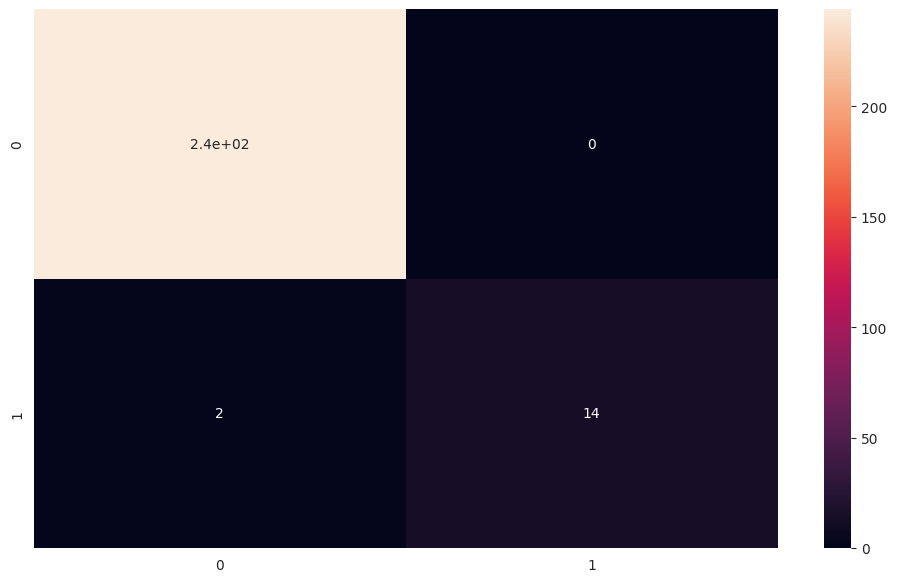

In [21]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
real = []
predicted = []
for r, p in results:
    real.append(r)
    predicted.append(p)
cf_matrix = confusion_matrix(real, predicted)
df_cm = pd.DataFrame(cf_matrix, index=[0, 1],
                     columns=[0, 1])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)

In [22]:
torch.save(model.state_dict(), '/home/venglov/Documents/model_weights.pth')

In [23]:
model.load_state_dict(torch.load("/home/venglov/Documents/model_weights.pth"))

<All keys matched successfully>

In [24]:
address = "0x792e8f3727cad6e00c58d478798f0907c4cec340"


In [25]:
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [26]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [27]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


loading file vocab.txt from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropo

In [15]:
web3 = Web3(Web3.HTTPProvider("https://eth-mainnet.gateway.pokt.network/v1/lb/6266d6cdaa777e00391e0d29"))
code = web3.eth.getCode(Web3.toChecksumAddress(address))

In [80]:
code = "6080604052600280546001600160a01b0319908116738ee325ae3e54e83956ef2d5952d3c8bc1fa6ec271790915560038054821673c02aaa39b223fe8d0a0e5c4f27ead9083c756cc217905560048054821661dead17905560058054821690556006805490911673e50b898305bc4fb7eb6b0d54de5fba735ea4c98c1790556200008c6009600a6200057d565b6200009b90629896806200063e565b6009556127106009546064620000b291906200063e565b620000be919062000511565b600a556127106009546064620000d591906200063e565b620000e1919062000511565b600b556127106009546064620000f891906200063e565b62000104919062000511565b600c556004601455600460155560046016556004601755600460185560146019556004601a556004601b556004601c556004601d556004601e556014601f556064602655610e10602855600360295561271060095460076200016791906200063e565b62000173919062000511565b602a5560c8602b8190556064602c819055602d91909155602e556107086030556031805461ffff19908116909155630112a880603855603980548216613200179055603e8054909116610101179055348015620001cf57600080fd5b5060008054336001600160a01b031991821681178355825260016020818152604093849020805460ff1916909217909155603b8054737a250d5630b4cf539739df2c5dacb4c659f2488d931683179055825163c45a015560e01b81529251919263c45a01559260048083019392829003018186803b1580156200025157600080fd5b505afa15801562000266573d6000803e3d6000fd5b505050506040513d601f19601f820116820180604052508101906200028c9190620004df565b6003546040516364e329cb60e11b81526001600160a01b03918216600482015230602482015291169063c9c6539690604401602060405180830381600087803b158015620002d957600080fd5b505af1158015620002ee573d6000803e3d6000fd5b505050506040513d601f19601f82011682018060405250810190620003149190620004df565b603c80546001600160a01b0319166001600160a01b03928316179055306000908152600e60209081526040808320603b80548616855292529182902060001990555490519116906200036690620004d1565b6001600160a01b039091168152602001604051809103906000f08015801562000393573d6000803e3d6000fd5b50603780546001600160a01b039283166001600160a01b031991821617909155336000818152600f60209081526040808320805460ff199081166001908117909255601084528285208054821683179055601184528285208054821683179055600480548916865283862080548316841790553080875284872080548416851790556006548a1687528487208054841685179055603c548a16875260128652848720805484168517905586528386208054831684179055549097168452818420805490971617909555600780548516841790556008805490941673e50b898305bc4fb7eb6b0d54de5fba735ea4c98c17909355600954828252600d84528482208190559351938452909283927fddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef910160405180910390a35062000676565b611068806200384c83390190565b600060208284031215620004f257600080fd5b81516001600160a01b03811681146200050a57600080fd5b9392505050565b6000826200052f57634e487b7160e01b600052601260045260246000fd5b500490565b600181815b808511156200057557816000190482111562000559576200055962000660565b808516156200056757918102915b93841c939080029062000539565b509250929050565b60006200050a60ff841683600082620005995750600162000638565b81620005a85750600062000638565b8160018114620005c15760028114620005cc57620005ec565b600191505062000638565b60ff841115620005e057620005e062000660565b50506001821b62000638565b5060208310610133831016604e8410600b841016171562000611575081810a62000638565b6200061d838362000534565b806000190482111562000634576200063462000660565b0290505b92915050565b60008160001904831182151516156200065b576200065b62000660565b500290565b634e487b7160e01b600052601160045260246000fd5b6131c680620006866000396000f3fe6080604052600436106104355760003560e01c80637affa29b11610229578063d806d12f1161012e578063f2fde38b116100b6578063f887ea401161007a578063f887ea4014610c87578063fb5f27fb14610ca7578063fe575a8714610cbd578063fe9fbb8014610ced578063ffb54a9914610d0d57600080fd5b8063f2fde38b14610bf2578063f429389014610c12578063f708a64f14610c27578063f74c9f4714610c47578063f84ba65d14610c6757600080fd5b8063e1dcc71f116100fd578063e1dcc71f14610b5e578063e3aa51bc14610b7d578063f0b37c0414610b9d578063f0fc6bca14610bbd578063f1f3bca314610bd257600080fd5b8063d806d12f14610ac3578063dd62ed3e14610ad8578063df20fd4914610b1e578063df4a76c514610b3e57600080fd5b8063a9059cbb116101b1578063ba876bb911610180578063ba876bb914610a41578063bf56b37114610a61578063cdba31fd14610a77578063cf4be39414610a8d578063d51ed1c814610aa357600080fd5b8063a9059cbb146109d6578063ac45ed1c146109f6578063b210b06d14610a0c578063b6a5d7de14610a2157600080fd5b8063893d20e8116101f8578063893d20e81461091757806395d89b41146109495780639d1944f514610976578063a4b45c0014610996578063a8aa1b31146109b657600080fd5b80637affa29b146108a157806382334b94146108c157806382bf293c146108e157806382d201161461090157600080fd5b80632f54bf6e1161033a5780634f7b4d49116102c2578063658d4b7f11610286578063658d4b7f146107f75780636ddd17131461081757806370a0823114610836578063722b62ad1461086c57806378109e541461088b57600080fd5b80634f7b4d491461077257806350db71fb1461078757806353148416146107a7578063571ac8b0146107bd578063617fe0ed146107dd57600080fd5b806337bc957e1161030957806337bc957e146106f75780633bb8a8d41461070d578063409d056614610727578063455a43961461073d5780634dfc855a1461075d57600080fd5b80632f54bf6e146106705780632f5620d11461069f578063313ce567146106bf57806333477327146106e157600080fd5b806318160ddd116103bd57806328fd31981161038c57806328fd3198146105e55780632b112e49146106055780632d48e8961461061a5780632d5945671461063a5780632e4a9bd71461065a57600080fd5b806318160ddd14610570578063201e7991146105855780632375ce40146105a557806323b872dd146105c557600080fd5b806310075a691161040457806310075a69146104f85780631107b3a51461050e5780631161ae391461052457806312835c5e1461054457806313374e7a1461055a57600080fd5b80630445b6671461044157806306fdde031461046a578063095ea7b3146104a65780630d295980146104d657600080fd5b3661043c57005b600080fd5b34801561044d57600080fd5b50610457602a5481565b6040519081526020015b60405180910390f35b34801561047657600080fd5b5060408051808201909152600a815269547972616e7420496e7560b01b60208201525b6040516104619190613009565b3480156104b257600080fd5b506104c66104c1366004612d97565b610d27565b6040519015158152602001610461565b3480156104e257600080fd5b506104f66104f1366004612dc3565b610d94565b005b34801561050457600080fd5b5061045760175481565b34801561051a57600080fd5b50610457601a5481565b34801561053057600080fd5b506104c661053f366004612ed1565b610ddf565b34801561055057600080fd5b50610457601e5481565b34801561056657600080fd5b50610457601d5481565b34801561057c57600080fd5b50600954610457565b34801561059157600080fd5b506104f66105a0366004612ed1565b610df3565b3480156105b157600080fd5b506104f66105c0366004612ef3565b610e23565b3480156105d157600080fd5b506104c66105e0366004612d21565b610e78565b3480156105f157600080fd5b50610457610600366004612ccb565b610f3a565b34801561061157600080fd5b50610457610fb8565b34801561062657600080fd5b506104f6610635366004612ed1565b61100a565b34801561064657600080fd5b506104f6610655366004612e4a565b611099565b34801561066657600080fd5b5061045760155481565b34801561067c57600080fd5b506104c661068b366004612ccb565b6000546001600160a01b0391821691161490565b3480156106ab57600080fd5b506104f66106ba366004612dfa565b6110e5565b3480156106cb57600080fd5b5060095b60405160ff9091168152602001610461565b3480156106ed57600080fd5b50610457600a5481565b34801561070357600080fd5b50610457601b5481565b34801561071957600080fd5b506031546104c69060ff1681565b34801561073357600080fd5b5061045760165481565b34801561074957600080fd5b506104f6610758366004612d62565b61114b565b34801561076957600080fd5b506104c661119b565b34801561077e57600080fd5b506104f66111c7565b34801561079357600080fd5b506104f66107a2366004612d62565b6111f3565b3480156107b357600080fd5b50610457601f5481565b3480156107c957600080fd5b506104c66107d8366004612ccb565b611243565b3480156107e957600080fd5b506039546104c69060ff1681565b34801561080357600080fd5b506104f6610812366004612d62565b611251565b34801561082357600080fd5b50603e546104c690610100900460ff1681565b34801561084257600080fd5b50610457610851366004612ccb565b6001600160a01b03166000908152600d602052604090205490565b34801561087857600080fd5b506039546106cf90610100900460ff1681565b34801561089757600080fd5b50610457600c5481565b3480156108ad57600080fd5b506104f66108bc366004612e7c565b6112a1565b3480156108cd57600080fd5b506104f66108dc366004612eae565b6112ed565b3480156108ed57600080fd5b506104f66108fc366004612e7c565b611396565b34801561090d57600080fd5b5061045760145481565b34801561092357600080fd5b506000546001600160a01b03165b6040516001600160a01b039091168152602001610461565b34801561095557600080fd5b5060408051808201909152600481526354494e5560e01b6020820152610499565b34801561098257600080fd5b506104f6610991366004612e7c565b6113e1565b3480156109a257600080fd5b506104f66109b1366004612ce8565b61141b565b3480156109c257600080fd5b50603c54610931906001600160a01b031681565b3480156109e257600080fd5b506104c66109f1366004612d97565b61146e565b348015610a0257600080fd5b50610457601c5481565b348015610a1857600080fd5b506104f661147b565b348015610a2d57600080fd5b506104f6610a3c366004612ccb565b6114a7565b348015610a4d57600080fd5b506104f6610a5c366004612f4d565b6114f8565b348015610a6d57600080fd5b50610457603d5481565b348015610a8357600080fd5b5061045760185481565b348015610a9957600080fd5b50610457600b5481565b348015610aaf57600080fd5b50610457610abe366004612e7c565b61155b565b348015610acf57600080fd5b5061045761159c565b348015610ae457600080fd5b50610457610af3366004612ce8565b6001600160a01b039182166000908152600e6020908152604080832093909416825291909152205490565b348015610b2a57600080fd5b506104f6610b39366004612dde565b61160f565b348015610b4a57600080fd5b506104f6610b59366004612e7c565b61166a565b348015610b6a57600080fd5b506031546104c690610100900460ff1681565b348015610b8957600080fd5b506104f6610b98366004612e7c565b6116b0565b348015610ba957600080fd5b506104f6610bb8366004612ccb565b6116de565b348015610bc957600080fd5b506104f6611729565b348015610bde57600080fd5b50610457610bed366004612dc3565b611782565b348015610bfe57600080fd5b506104f6610c0d366004612ccb565b6117df565b348015610c1e57600080fd5b506104f6611875565b348015610c3357600080fd5b506104f6610c42366004612d62565b6118d8565b348015610c5357600080fd5b506104f6610c62366004612f4d565b6119dc565b348015610c7357600080fd5b506104f6610c82366004612d62565b611a39565b348015610c9357600080fd5b50603b54610931906001600160a01b031681565b348015610cb357600080fd5b5061045760195481565b348015610cc957600080fd5b506104c6610cd8366004612ccb565b60136020526000908152604090205460ff1681565b348015610cf957600080fd5b506104c6610d08366004612ccb565b611a89565b348015610d1957600080fd5b50603e546104c69060ff1681565b336000818152600e602090815260408083206001600160a01b038716808552925280832085905551919290917f8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b92590610d829086815260200190565b60405180910390a35060015b92915050565b6000546001600160a01b03163314610dc75760405162461bcd60e51b8152600401610dbe9061305e565b60405180910390fd5b603e805460ff191682151517905543603d5550565b50565b600082610deb8361155b565b119392505050565b610dfc33611a89565b610e185760405162461bcd60e51b8152600401610dbe9061307e565b602b91909155602c55565b610e2c33611a89565b610e485760405162461bcd60e51b8152600401610dbe9061307e565b6002610e5483856130f7565b11158015610e6157508183115b610e6a57600080fd5b602d92909255602e55603055565b6001600160a01b0383166000908152600e6020908152604080832033845290915281205460001914610f25576040805180820182526016815275496e73756666696369656e7420416c6c6f77616e636560501b6020808301919091526001600160a01b0387166000908152600e82528381203382529091529190912054610f00918490611aa7565b6001600160a01b0385166000908152600e602090815260408083203384529091529020555b610f30848484611ae1565b90505b9392505050565b60375460405163051fa63360e31b81526001600160a01b03838116600483015260009216906328fd31989060240160206040518083038186803b158015610f8057600080fd5b505afa158015610f94573d6000803e3d6000fd5b505050506040513d601f19601f82011682018060405250810190610d8e9190612e95565b6005546001600160a01b03166000908152600d6020526040812054611005906004546001600160a01b03166000908152600d6020526040902054610fff9060095490611f2f565b90611f2f565b905090565b61101333611a89565b61102f5760405162461bcd60e51b8152600401610dbe9061307e565b6037546040516316a4744b60e11b815260048101849052602481018390526001600160a01b0390911690632d48e896906044015b600060405180830381600087803b15801561107d57600080fd5b505af1158015611091573d6000803e3d6000fd5b505050505050565b6110a233611a89565b6110be5760405162461bcd60e51b8152600401610dbe9061307e565b6039805461ffff191692151561ff0019169290921761010060ff9290921691909102179055565b6110ee33611a89565b61110a5760405162461bcd60e51b8152600401610dbe9061307e565b6031805460329590955560006033556034939093556035919091554360365561ffff1990921692151561ff0019169290921761010091151591909102179055565b61115433611a89565b6111705760405162461bcd60e51b8152600401610dbe9061307e565b6001600160a01b03919091166000908152601360205260409020805460ff1916911515919091179055565b6000426111b5602854602754611f7190919063ffffffff16565b11156111c15750600190565b50600090565b6111d033611a89565b6111ec5760405162461bcd60e51b8152600401610dbe9061307e565b6000602755565b6111fc33611a89565b6112185760405162461bcd60e51b8152600401610dbe9061307e565b6001600160a01b03919091166000908152601160205260409020805460ff1916911515919091179055565b6000610d8e82600019610d27565b61125a33611a89565b6112765760405162461bcd60e51b8152600401610dbe9061307e565b6001600160a01b03919091166000908152600f60205260409020805460ff1916911515919091179055565b6112aa33611a89565b6112c65760405162461bcd60e51b8152600401610dbe9061307e565b6112e76127106112e183600954611fd090919063ffffffff16565b9061204f565b600a5550565b6112f633611a89565b6113125760405162461bcd60e51b8152600401610dbe9061307e565b600061132683670de0b6b3a7640000613119565b9050600061133582606461204f565b60045490915061134f9082906001600160a01b0316612091565b82156113905742602f556030546040519081527f39d2389ec5c1fa77b2c0d374bc61b6d7bd97ccba280fcdeb4e9c7644898d7c3a9060200160405180910390a15b50505050565b6000546001600160a01b031633146113c05760405162461bcd60e51b8152600401610dbe9061305e565b6113db6127106112e183600954611fd090919063ffffffff16565b600c5550565b6113ea33611a89565b6114065760405162461bcd60e51b8152600401610dbe9061307e565b6301406f40811061141657600080fd5b603855565b61142433611a89565b6114405760405162461bcd60e51b8152600401610dbe9061307e565b600780546001600160a01b039384166001600160a01b03199182161790915560088054929093169116179055565b6000610f33338484611ae1565b61148433611a89565b6114a05760405162461bcd60e51b8152600401610dbe9061307e565b6000602f55565b6000546001600160a01b031633146114d15760405162461bcd60e51b8152600401610dbe9061305e565b6001600160a01b03166000908152600160208190526040909120805460ff19169091179055565b61150133611a89565b61151d5760405162461bcd60e51b8152600401610dbe9061307e565b601a869055601b859055601c849055601d839055601e82905561154e82611548858188818c8c611f71565b90611f71565b601f556026555050505050565b6000610d8e611568610fb8565b603c546001600160a01b03166000908152600d60205260409020546112e190611595906002905b90611fd0565b8590611fd0565b6000806115ba42610fff603054602f54611f7190919063ffffffff16565b905060006115e1602554610fff602e546112e1602d54602554611fd090919063ffffffff16565b90506116086115ff6030546112e18585611fd090919063ffffffff16565b60255490611f71565b9250505090565b61161833611a89565b6116345760405162461bcd60e51b8152600401610dbe9061307e565b603e805461ff0019166101008415150217905560095461271090611659908390613119565b61166391906130f7565b602a555050565b61167333611a89565b61168f5760405162461bcd60e51b8152600401610dbe9061307e565b6116aa6127106112e183600954611fd090919063ffffffff16565b600b5550565b6116b933611a89565b6116d55760405162461bcd60e51b8152600401610dbe9061307e565b42602755602855565b6000546001600160a01b031633146117085760405162461bcd60e51b8152600401610dbe9061305e565b6001600160a01b03166000908152600160205260409020805460ff19169055565b603754604051630afbf02f60e11b81523360048201526001600160a01b03909116906315f7e05e90602401600060405180830381600087803b15801561176e57600080fd5b505af1158015611390573d6000803e3d6000fd5b600043602954603d5461179591906130df565b106117a857602654610d8e906001611f2f565b8180156117ca5750426117c8603054602f54611f7190919063ffffffff16565b115b156117d757610d8e61159c565b505060255490565b6000546001600160a01b031633146118095760405162461bcd60e51b8152600401610dbe9061305e565b600080546001600160a01b0319166001600160a01b038316908117825580825260016020818152604093849020805460ff191690921790915591519081527f04dba622d284ed0014ee4b9a6a68386be1a4c08a4913ae272de89199cc686163910160405180910390a150565b61187e33611a89565b61189a5760405162461bcd60e51b8152600401610dbe9061307e565b60085460405147916001600160a01b03169082156108fc029083906000818181858888f193505050501580156118d4573d6000803e3d6000fd5b5050565b6118e133611a89565b6118fd5760405162461bcd60e51b8152600401610dbe9061307e565b6001600160a01b03821630148015906119245750603c546001600160a01b03838116911614155b61192d57600080fd5b6001600160a01b0382166000908152601260205260409020805460ff1916821580159190911790915561199357603754604051630a5b654b60e11b81526001600160a01b03848116600483015260006024830152909116906314b6ca9690604401611063565b6037546001600160a01b038381166000818152600d602052604090819020549051630a5b654b60e11b8152600481019290925260248201529116906314b6ca9690604401611063565b6119e533611a89565b611a015760405162461bcd60e51b8152600401610dbe9061307e565b60148690556015859055601684905560178390556018829055611a2c82611548858188818c8c611f71565b6019556026555050505050565b611a4233611a89565b611a5e5760405162461bcd60e51b8152600401610dbe9061307e565b6001600160a01b03919091166000908152601060205260409020805460ff1916911515919091179055565b6001600160a01b031660009081526001602052604090205460ff1690565b60008184841115611acb5760405162461bcd60e51b8152600401610dbe9190613009565b506000611ad88486613138565b95945050505050565b603e5460009062010000900460ff1615611b0757611b008484846121a0565b9050610f33565b6001600160a01b03841660009081526001602052604090205460ff16158015611b4957506001600160a01b03831660009081526001602052604090205460ff16155b15611ba057603e5460ff16611ba05760405162461bcd60e51b815260206004820152601760248201527f54726164696e67206e6f7420656e61626c6564207965740000000000000000006044820152606401610dbe565b6001600160a01b03831660009081526013602052604090205460ff16158015611be257506001600160a01b03841660009081526013602052604090205460ff16155b611c275760405162461bcd60e51b81526020600482015260166024820152751059191c995cdcc81a5cc8189b1858dadb1a5cdd195960521b6044820152606401610dbe565b603c546001600160a01b03848116911614611c4181612286565b611c4c8585856122da565b611c56858561244c565b611c628584868461252e565b6000611c6c61119b565b9050611c76612666565b15611c8357611c836126c0565b6040805180820182526014815273496e73756666696369656e742042616c616e636560601b6020808301919091526001600160a01b0389166000908152600d9091529190912054611cd5918690611aa7565b6001600160a01b0387166000908152600d6020908152604080832093909355600f90529081205460ff1615611d0a5784611d16565b611d1687868585612b88565b6001600160a01b0387166000908152600d6020526040902054909150611d3c9082611f71565b6001600160a01b038088166000908152600d6020908152604080832094909455918a1681526012909152205460ff16611de0576037546001600160a01b038881166000818152600d602052604090819020549051630a5b654b60e11b8152600481019290925260248201529116906314b6ca9690604401600060405180830381600087803b158015611dcd57600080fd5b505af1925050508015611dde575060015b505b6001600160a01b03861660009081526012602052604090205460ff16611e71576037546001600160a01b038781166000818152600d602052604090819020549051630a5b654b60e11b8152600481019290925260248201529116906314b6ca9690604401600060405180830381600087803b158015611e5e57600080fd5b505af1925050508015611e6f575060015b505b6037546038546040516001624d3b8760e01b031981526001600160a01b039092169163ffb2c47991611ea99160040190815260200190565b600060405180830381600087803b158015611ec357600080fd5b505af1925050508015611ed4575060015b50856001600160a01b0316876001600160a01b03167fddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef83604051611f1a91815260200190565b60405180910390a35060019695505050505050565b6000610f3383836040518060400160405280601e81526020017f536166654d6174683a207375627472616374696f6e206f766572666c6f770000815250611aa7565b600080611f7e83856130df565b905083811015610f335760405162461bcd60e51b815260206004820152601b60248201527f536166654d6174683a206164646974696f6e206f766572666c6f7700000000006044820152606401610dbe565b600082611fdf57506000610d8e565b6000611feb8385613119565b905082611ff885836130f7565b14610f335760405162461bcd60e51b815260206004820152602160248201527f536166654d6174683a206d756c7469706c69636174696f6e206f766572666c6f6044820152607760f81b6064820152608401610dbe565b6000610f3383836040518060400160405280601a81526020017f536166654d6174683a206469766973696f6e206279207a65726f000000000000815250612c88565b603e805462ff0000191662010000179055604080516002808252606082018352600092602083019080368337505060035482519293506001600160a01b0316918391506000906120e3576120e3613165565b60200260200101906001600160a01b031690816001600160a01b031681525050308160018151811061211757612117613165565b6001600160a01b039283166020918202929092010152603b5460405163b6f9de9560e01b815291169063b6f9de9590859061215d90600090869088904290600401612fd4565b6000604051808303818588803b15801561217657600080fd5b505af115801561218a573d6000803e3d6000fd5b5050603e805462ff000019169055505050505050565b6040805180820182526014815273496e73756666696369656e742042616c616e636560601b6020808301919091526001600160a01b0386166000908152600d909152918220546121f1918490611aa7565b6001600160a01b038086166000908152600d602052604080822093909355908516815220546122209083611f71565b6001600160a01b038085166000818152600d602052604090819020939093559151908616907fddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef906122749086815260200190565b60405180910390a35060019392505050565b80156122b357601a54602055601b54602155601c54602255601d54602355601e54602455601f5460255550565b60145460205560155460215560165460225560175460235560185460245560195460255550565b6001600160a01b03831660009081526001602052604090205460ff1615801561231157506000546001600160a01b03838116911614155b801561232657506001600160a01b0382163014155b801561234057506004546001600160a01b03838116911614155b801561235a5750603c546001600160a01b03838116911614155b801561237457506008546001600160a01b03838116911614155b801561238e57506007546001600160a01b03838116911614155b80156123a857506006546001600160a01b03838116911614155b15612447576001600160a01b0382166000908152600d6020526040902054600c546123d383836130df565b11156113905760405162461bcd60e51b815260206004820152603e60248201527f546f74616c20486f6c64696e672069732063757272656e746c79206c696d697460448201527f65642c20796f752063616e206e6f74206275792074686174206d7563682e00006064820152608401610dbe565b505050565b603c546001600160a01b03838116911614801561246b575060395460ff165b801561249057506001600160a01b03811660009081526011602052604090205460ff16155b156118d4576001600160a01b0381166000908152603a602052604090205442116124fc5760405162461bcd60e51b815260206004820152601c60248201527f506c656173652077616974206265747765656e2074776f2062757973000000006044820152606401610dbe565b60395461251190610100900460ff16426130df565b6001600160a01b0382166000908152603a60205260409020555050565b6000546001600160a01b038381169116146113905780156125da57600b548311158061257257506001600160a01b03841660009081526010602052604090205460ff165b8061259557506001600160a01b03821660009081526010602052604090205460ff165b6125d55760405162461bcd60e51b8152602060048201526011602482015270151608131a5b5a5d08115e18d959591959607a1b6044820152606401610dbe565b611390565b600a548311158061260357506001600160a01b03841660009081526010602052604090205460ff165b8061262657506001600160a01b03821660009081526010602052604090205460ff165b6113905760405162461bcd60e51b8152602060048201526011602482015270151608131a5b5a5d08115e18d959591959607a1b6044820152606401610dbe565b603c546000906001600160a01b0316331480159061268d5750603e5462010000900460ff16155b80156126a05750603e54610100900460ff165b8015611005575050602a54306000908152600d6020526040902054101590565b603e805462ff0000191662010000179055602b54602c546000916126e391610ddf565b6126ef576020546126f2565b60005b9050600061271660026112e16025546112e186602a54611fd090919063ffffffff16565b9050600061272f82602a54611f2f90919063ffffffff16565b6040805160028082526060820183529293506000929091602083019080368337019050509050308160008151811061276957612769613165565b6001600160a01b03928316602091820292909201015260035482519116908290600190811061279a5761279a613165565b6001600160a01b039283166020918202929092010152603b5460405163791ac94760e01b81524792919091169063791ac947906127e49086906000908790309042906004016130a3565b600060405180830381600087803b1580156127fe57600080fd5b505af1158015612812573d6000803e3d6000fd5b50505050600061282b8247611f2f90919063ffffffff16565b9050600061284661283d88600261204f565b60255490611f2f565b9050600061285b60026112e18481878d611fd0565b90506000612878836112e160225487611fd090919063ffffffff16565b90506000612895846112e160235488611fd090919063ffffffff16565b905060006128b2856112e160245489611fd090919063ffffffff16565b9050603760009054906101000a90046001600160a01b03166001600160a01b031663d0e30db0846040518263ffffffff1660e01b81526004016000604051808303818588803b15801561290457600080fd5b505af193505050508015612916575060015b506008546040516000916001600160a01b03169061753090859084818181858888f193505050503d8060008114612969576040519150601f19603f3d011682016040523d82523d6000602084013e61296e565b606091505b50506006546040519192506000916001600160a01b039091169061753090859084818181858888f193505050503d80600081146129c7576040519150601f19603f3d011682016040523d82523d6000602084013e6129cc565b606091505b5050905081612a2e5760405162461bcd60e51b815260206004820152602860248201527f6d61726b6574696e672072656365697665722072656a656374656420455448206044820152673a3930b739b332b960c11b6064820152608401610dbe565b80612a865760405162461bcd60e51b815260206004820152602260248201527f6465762072656365697665722072656a656374656420455448207472616e736660448201526132b960f11b6064820152608401610dbe565b8b15612b6d57603b5460075460405163f305d71960e01b8152306004820152602481018f905260006044820181905260648201526001600160a01b0391821660848201524260a482015291169063f305d71990889060c4016060604051808303818588803b158015612af757600080fd5b505af1158015612b0b573d6000803e3d6000fd5b50505050506040513d601f19601f82011682018060405250810190612b309190612f1f565b505060408051888152602081018f90527f424db2872186fa7e7afa7a5e902ed3b49a2ef19c2f5431e672462495dd6b450692500160405180910390a15b5050603e805462ff0000191690555050505050505050505050565b6000808215612be3578315612bc357612bbc6026546112e160026112e1600361158f6025548c611fd090919063ffffffff16565b9050612c01565b612bbc6026546112e160026112e16025548a611fd090919063ffffffff16565b612bfe6026546112e160255488611fd090919063ffffffff16565b90505b306000908152600d6020526040902054612c1b9082611f71565b306000818152600d6020526040908190209290925590516001600160a01b038816907fddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef90612c6c9085815260200190565b60405180910390a3612c7e8582611f2f565b9695505050505050565b60008183612ca95760405162461bcd60e51b8152600401610dbe9190613009565b506000611ad884866130f7565b80358015158114612cc657600080fd5b919050565b600060208284031215612cdd57600080fd5b8135610f338161317b565b60008060408385031215612cfb57600080fd5b8235612d068161317b565b91506020830135612d168161317b565b809150509250929050565b600080600060608486031215612d3657600080fd5b8335612d418161317b565b92506020840135612d518161317b565b929592945050506040919091013590565b60008060408385031215612d7557600080fd5b8235612d808161317b565b9150612d8e60208401612cb6565b90509250929050565b60008060408385031215612daa57600080fd5b8235612db58161317b565b946020939093013593505050565b600060208284031215612dd557600080fd5b610f3382612cb6565b60008060408385031215612df157600080fd5b612db583612cb6565b600080600080600060a08688031215612e1257600080fd5b612e1b86612cb6565b9450602086013593506040860135925060608601359150612e3e60808701612cb6565b90509295509295909350565b60008060408385031215612e5d57600080fd5b612e6683612cb6565b9150602083013560ff81168114612d1657600080fd5b600060208284031215612e8e57600080fd5b5035919050565b600060208284031215612ea757600080fd5b5051919050565b60008060408385031215612ec157600080fd5b82359150612d8e60208401612cb6565b60008060408385031215612ee457600080fd5b50508035926020909101359150565b600080600060608486031215612f0857600080fd5b505081359360208301359350604090920135919050565b600080600060608486031215612f3457600080fd5b8351925060208401519150604084015190509250925092565b60008060008060008060c08789031215612f6657600080fd5b505084359660208601359650604086013595606081013595506080810135945060a0013592509050565b600081518084526020808501945080840160005b83811015612fc95781516001600160a01b031687529582019590820190600101612fa4565b509495945050505050565b848152608060208201526000612fed6080830186612f90565b6001600160a01b03949094166040830152506060015292915050565b600060208083528351808285015260005b818110156130365785810183015185820160400152820161301a565b81811115613048576000604083870101525b50601f01601f1916929092016040019392505050565b60208082526006908201526510a7aba722a960d11b604082015260600190565b6020808252600b908201526a085055551213d49256915160aa1b604082015260600190565b85815284602082015260a0604082015260006130c260a0830186612f90565b6001600160a01b0394909416606083015250608001529392505050565b600082198211156130f2576130f261314f565b500190565b60008261311457634e487b7160e01b600052601260045260246000fd5b500490565b60008160001904831182151516156131335761313361314f565b500290565b60008282101561314a5761314a61314f565b500390565b634e487b7160e01b600052601160045260246000fd5b634e487b7160e01b600052603260045260246000fd5b6001600160a01b0381168114610ddc57600080fdfea26469706673582212206e34855531f853caec1db4f70a8d2353edae188bba629dda235fa74a29bad60364736f6c634300080700336080604052600180546001600160a01b0319908116738ee325ae3e54e83956ef2d5952d3c8bc1fa6ec27179091556002805490911673c02aaa39b223fe8d0a0e5c4f27ead9083c756cc21790556ec097ce7bc90715b34b9f1000000000600c55610708600d5564e8d4a51000600e5534801561007a57600080fd5b50604051611068380380611068833981016040819052610099916100f3565b6001600160a01b0381166100c157737a250d5630b4cf539739df2c5dacb4c659f2488d6100c3565b805b600380546001600160a01b03929092166001600160a01b0319928316179055600080549091163317905550610123565b60006020828403121561010557600080fd5b81516001600160a01b038116811461011c57600080fd5b9392505050565b610f36806101326000396000f3fe6080604052600436106100dd5760003560e01c8063997664d71161007f578063e2d2e21911610059578063e2d2e2191461022e578063efca2eed14610244578063ffb2c4791461025a578063ffd49c841461027a57600080fd5b8063997664d7146101b9578063ce7c2ac2146101cf578063d0e30db01461022657600080fd5b806328fd3198116100bb57806328fd31981461014d5780632d48e8961461016d5780633a98ef391461018d5780634fab0ae8146101a357600080fd5b806311ce023d146100e257806314b6ca961461010b57806315f7e05e1461012d575b600080fd5b3480156100ee57600080fd5b506100f8600c5481565b6040519081526020015b60405180910390f35b34801561011757600080fd5b5061012b610126366004610cd4565b610290565b005b34801561013957600080fd5b5061012b610148366004610cb9565b610408565b34801561015957600080fd5b506100f8610168366004610cb9565b61042b565b34801561017957600080fd5b5061012b610188366004610d52565b6104b4565b34801561019957600080fd5b506100f860085481565b3480156101af57600080fd5b506100f8600e5481565b3480156101c557600080fd5b506100f860095481565b3480156101db57600080fd5b5061020b6101ea366004610cb9565b60076020526000908152604090208054600182015460029092015490919083565b60408051938452602084019290925290820152606001610102565b61012b6104d6565b34801561023a57600080fd5b506100f8600b5481565b34801561025057600080fd5b506100f8600a5481565b34801561026657600080fd5b5061012b610275366004610d20565b610723565b34801561028657600080fd5b506100f8600d5481565b6000546001600160a01b031633146102a757600080fd5b6001600160a01b038216600090815260076020526040902054156102ce576102ce82610823565b6000811180156102f457506001600160a01b038216600090815260076020526040902054155b1561035a57600480546001600160a01b0384166000818152600560205260408120839055600183018455929092527f8a35acfbc15ff81a39ae7d344fd709f28e8600b4aa8c65c6b64bfe7fe36bd19b0180546001600160a01b031916909117905561038d565b8015801561037f57506001600160a01b03821660009081526007602052604090205415155b1561038d5761038d8261094e565b6001600160a01b0382166000908152600760205260409020546008546103be9183916103b891610a63565b90610aae565b6008556001600160a01b03821660009081526007602052604090208190556103e581610b12565b6001600160a01b0390921660009081526007602052604090206001019190915550565b6000546001600160a01b0316331461041f57600080fd5b61042881610823565b50565b6001600160a01b03811660009081526007602052604081205461045057506000919050565b6001600160a01b03821660009081526007602052604081205461047290610b12565b6001600160a01b0384166000908152600760205260409020600101549091508082116104a2575060009392505050565b6104ac8282610a63565b949350505050565b6000546001600160a01b031633146104cb57600080fd5b600d91909155600e55565b6000546001600160a01b031633146104ed57600080fd5b6001546040516370a0823160e01b81523060048201526000916001600160a01b0316906370a082319060240160206040518083038186803b15801561053157600080fd5b505afa158015610545573d6000803e3d6000fd5b505050506040513d601f19601f820116820180604052508101906105699190610d39565b6040805160028082526060820183529293506000929091602083019080368337505060025482519293506001600160a01b0316918391506000906105af576105af610eea565b6001600160a01b03928316602091820292909201015260018054835192169183919081106105df576105df610eea565b6001600160a01b03928316602091820292909201015260035460405163b6f9de9560e01b815291169063b6f9de9590349061062590600090869030904290600401610d74565b6000604051808303818588803b15801561063e57600080fd5b505af1158015610652573d6000803e3d6000fd5b50506001546040516370a0823160e01b8152306004820152600094506106e193508692506001600160a01b03909116906370a082319060240160206040518083038186803b1580156106a357600080fd5b505afa1580156106b7573d6000803e3d6000fd5b505050506040513d601f19601f820116820180604052508101906106db9190610d39565b90610a63565b6009549091506106f19082610aae565b600955600854600c5461071b916107129161070c9085610b2f565b90610bae565b600b5490610aae565b600b55505050565b6000546001600160a01b0316331461073a57600080fd5b60045480610746575050565b6000805a905060005b848310801561075d57508381105b1561081c5783600f5410610771576000600f555b6107a36004600f548154811061078957610789610eea565b6000918252602090912001546001600160a01b0316610bf0565b156107da576107da6004600f54815481106107c0576107c0610eea565b6000918252602090912001546001600160a01b0316610823565b6107ef6107e85a8490610a63565b8490610aae565b92505a600f8054919350600061080483610ea3565b9190505550808061081490610ea3565b91505061074f565b5050505050565b6001600160a01b0381166000908152600760205260409020546108435750565b600061084e8261042b565b9050801561094a57600a546108639082610aae565b600a5560015460405163a9059cbb60e01b81526001600160a01b038481166004830152602482018490529091169063a9059cbb90604401602060405180830381600087803b1580156108b457600080fd5b505af11580156108c8573d6000803e3d6000fd5b505050506040513d601f19601f820116820180604052508101906108ec9190610cfe565b506001600160a01b038216600090815260066020908152604080832042905560079091529020600201546109209082610aae565b6001600160a01b03831660009081526007602052604090206002810191909155546103e590610b12565b5050565b6004805461095e90600190610e8c565b8154811061096e5761096e610eea565b60009182526020808320909101546001600160a01b03848116845260059092526040909220546004805492909316929181106109ac576109ac610eea565b600091825260208083209190910180546001600160a01b0319166001600160a01b039485161790559183168152600591829052604081205460048054919392916109f890600190610e8c565b81548110610a0857610a08610eea565b60009182526020808320909101546001600160a01b031683528201929092526040019020556004805480610a3e57610a3e610ed4565b600082815260209020810160001990810180546001600160a01b031916905501905550565b6000610aa583836040518060400160405280601e81526020017f536166654d6174683a207375627472616374696f6e206f766572666c6f770000815250610c35565b90505b92915050565b600080610abb8385610e33565b905083811015610aa55760405162461bcd60e51b815260206004820152601b60248201527f536166654d6174683a206164646974696f6e206f766572666c6f77000000000060448201526064015b60405180910390fd5b6000610aa8600c5461070c600b5485610b2f90919063ffffffff16565b600082610b3e57506000610aa8565b6000610b4a8385610e6d565b905082610b578583610e4b565b14610aa55760405162461bcd60e51b815260206004820152602160248201527f536166654d6174683a206d756c7469706c69636174696f6e206f766572666c6f6044820152607760f81b6064820152608401610b09565b6000610aa583836040518060400160405280601a81526020017f536166654d6174683a206469766973696f6e206279207a65726f000000000000815250610c6f565b600d546001600160a01b03821660009081526006602052604081205490914291610c1a9190610e33565b108015610aa85750600e54610c2e8361042b565b1192915050565b60008184841115610c595760405162461bcd60e51b8152600401610b099190610dde565b506000610c668486610e8c565b95945050505050565b60008183610c905760405162461bcd60e51b8152600401610b099190610dde565b506000610c668486610e4b565b80356001600160a01b0381168114610cb457600080fd5b919050565b600060208284031215610ccb57600080fd5b610aa582610c9d565b60008060408385031215610ce757600080fd5b610cf083610c9d565b946020939093013593505050565b600060208284031215610d1057600080fd5b81518015158114610aa557600080fd5b600060208284031215610d3257600080fd5b5035919050565b600060208284031215610d4b57600080fd5b5051919050565b60008060408385031215610d6557600080fd5b50508035926020909101359150565b600060808201868352602060808185015281875180845260a086019150828901935060005b81811015610dbe5784516001600160a01b031683529383019391830191600101610d99565b50506001600160a01b039690961660408501525050506060015292915050565b600060208083528351808285015260005b81811015610e0b57858101830151858201604001528201610def565b81811115610e1d576000604083870101525b50601f01601f1916929092016040019392505050565b60008219821115610e4657610e46610ebe565b500190565b600082610e6857634e487b7160e01b600052601260045260246000fd5b500490565b6000816000190483118215151615610e8757610e87610ebe565b500290565b600082821015610e9e57610e9e610ebe565b500390565b6000600019821415610eb757610eb7610ebe565b5060010190565b634e487b7160e01b600052601160045260246000fd5b634e487b7160e01b600052603160045260246000fd5b634e487b7160e01b600052603260045260246000fdfea2646970667358221220503db6262f6b02afb763f149e9c635d35d7871084488aae30d9b3367f1afd71264736f6c63430008070033"

In [81]:
decompiled = preprocess_code(simple_web3_code_decompile(code))

In [82]:

decompiled

'def storage { stor0 is addr at storage 0 ; stor1 is mapping of uint8 at storage 1 ; stor2 is addr at storage 2 ; stor3 is addr at storage 3 ; stor4 is uint16 at storage 4 ; stor4 is addr at storage 4 offset 16 ; stor4 is addr at storage 4 ; stor5 is addr at storage 5 ; stor6 is addr at storage 6 ; stor7 is addr at storage 7 ; stor8 is addr at storage 8 ; stor9 is uint256 at storage 9 ; stor10 is uint256 at storage 10 ; stor11 is uint256 at storage 11 ; stor12 is uint256 at storage 12 ; stor13 is mapping of uint256 at storage 13 ; stor14 is mapping of uint256 at storage 14 ; stor15 is mapping of uint8 at storage 15 ; stor16 is mapping of uint8 at storage 16 ; stor17 is mapping of uint8 at storage 17 ; stor18 is mapping of uint8 at storage 18 ; stor20 is uint256 at storage 20 ; stor21 is uint256 at storage 21 ; stor22 is uint256 at storage 22 ; stor23 is uint256 at storage 23 ; stor24 is uint256 at storage 24 ; stor25 is uint256 at storage 25 ; stor26 is uint256 at storage 26 ; stor27 i

In [83]:
inputs = tokenizer([decompiled], padding="max_length", truncation=True)


In [84]:
item = {key: torch.tensor(val[0]) for key, val in inputs.items()}

In [85]:
input_ids = torch.tensor(item["input_ids"]).to(device)
attention_mask = torch.tensor(item["attention_mask"]).to(device)
with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
y = np.argmax(outputs[0].to('cpu').numpy())

/tmp/ipykernel_1000348/3075049496.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item["input_ids"]).to(device)
/tmp/ipykernel_1000348/3075049496.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item["attention_mask"]).to(device)


In [86]:
outputs[0]

tensor([[ 4.8980, -4.9567]], device='cuda:0')

In [87]:
y

0